# Demonstrate limit cycle of single and coupled CPG

In [70]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPG, CPGParameters

def generate_state_history(
    initial_state, 
    dt = 0.001, 
    n_timesteps = 200
):
    """ Generate reference foot contacts for plotting """
    params = CPGParameters(
        a=1.0,
        b=50.0,
        mu=1.0,
        alpha=10.0,
        beta=0.5,
        gamma=50.0,
        period=1 / 1.0,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg_system = CPG(
        params=params,
        initial_state=initial_state
    )

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 2))
    phase_history = np.zeros((n_timesteps))
    for i in range(n_timesteps):
        state_history[i] = cpg_system.get_state()
        phase_history[i] = cpg_system.get_phase()
        cpg_system.step(extrinsic_delta_state=np.zeros(2))
    
    return time, state_history

import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

phase_offsets = {
    "walk": np.array([3 * np.pi / 2, np.pi / 2, np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = lambda phase: 2 * (phase > 0).astype(int) - 1
foot_names = ['FR', 'FL', 'RR', 'RL']

def generate_all_phase_history(
    initial_state,
    gait_name, 
    gait_frequency, 
    duty_factor, 
    dt = 0.025, 
    n_timesteps = 200
):
    """ Generate reference foot contacts for plotting """
    params = CPGParameters(
        a=1.0,
        b=50.0,
        mu=1.0,
        alpha=10.0,
        beta=duty_factor,
        gamma=50.0,
        period=1 / gait_frequency,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg_system = CPGSystem(
        params=params,
        coupling_strength=1,
        desired_phase_offsets=phase_offsets[gait_name],
        initial_state=initial_state,
    )

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 4, 2))
    phase_history = np.zeros((n_timesteps, 4))
    foot_contacts = np.zeros((n_timesteps, 4))
    for i in range(n_timesteps):
        state_history[i] = cpg_system.get_state()
        phase_history[i] = cpg_system.get_phase()
        foot_contacts[i] = foot_contact_fn(phase_history[i])
        cpg_system.step()
    
    return time, np.cos(phase_history)

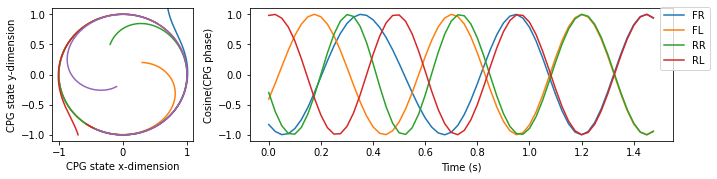

In [101]:
trajectories = []
initial_states = (
    np.array([0.7, 1.1]),
    np.array([0.3, 0.2]),
    np.array([-0.2, 0.5]),
    np.array([-0.7, -1.0]),
    np.array([-0.1, -0.2])
)

for i in range(5): 
    _, state_history = generate_state_history(initial_states[i], dt = 0.001, n_timesteps=1000)
    trajectories.append(state_history)

four_initial_state = np.random.uniform(-1.2, 1.2, size=(4,2))
time, all_phase_history = generate_all_phase_history(four_initial_state, 'trot', 2.0, 0.5, n_timesteps=60)

fig, ax = plt.subplots(1,2, figsize=(10.0,2.6), gridspec_kw={'width_ratios': [1,3]})
# Plot single CPG limit cycle
ax[0].set_xlabel('CPG state x-dimension')
ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylabel('CPG state y-dimension')
ax[0].set_ylim(-1.1, 1.1)
for i, t in enumerate(trajectories):
    ax[0].plot(t[:,0], t[:,1])

# Plot phase synchronization of multiple CPGs
ax[1].set_ylabel('Cosine(CPG phase)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(-1.1, 1.1)
for j in range(4):
    ax[1].plot(time, all_phase_history[:,j], label=foot_names[j])
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()


# Generate plots of Foot Contacts

In [ ]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

phase_offsets = {
    "walk": np.array([3 * np.pi / 2, np.pi / 2, np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = lambda phase: 2 * (phase > 0).astype(int) - 1
foot_names = ['FR', 'FL', 'RR', 'RL']

def generate_foot_contacts(
    gait_name, 
    gait_frequency, 
    duty_factor, 
    dt = 0.025, 
    n_timesteps = 200
):
    """ Generate reference foot contacts for plotting """
    params = CPGParameters(
        a=1.0,
        b=50.0,
        mu=1.0,
        alpha=10.0,
        beta=duty_factor,
        gamma=50.0,
        period=1 / gait_frequency,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg_system = CPGSystem(
        params=params,
        coupling_strength=1,
        desired_phase_offsets=phase_offsets[gait_name],
        initial_state=CPGSystem.sample_initial_state(phase_offsets[gait_name]),
    )

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 4, 2))
    phase_history = np.zeros((n_timesteps, 4))
    foot_contacts = np.zeros((n_timesteps, 4))
    for i in range(n_timesteps):
        state_history[i] = cpg_system.get_state()
        phase_history[i] = cpg_system.get_phase()
        foot_contacts[i] = foot_contact_fn(phase_history[i])
        cpg_system.step()
    
    return time, foot_contacts

In [ ]:
vary_freq_foot_contacts = []
gait_freqs = (1.5, 2.0, 2.5)

for gf in gait_freqs: 
    _, f = generate_foot_contacts('trot', gf, 0.5, n_timesteps = 50)
    name = f"gait-freq-{gf}Hz"
    vary_freq_foot_contacts.append((name, f))
time = _

/tmp/ipykernel_30604/238773684.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


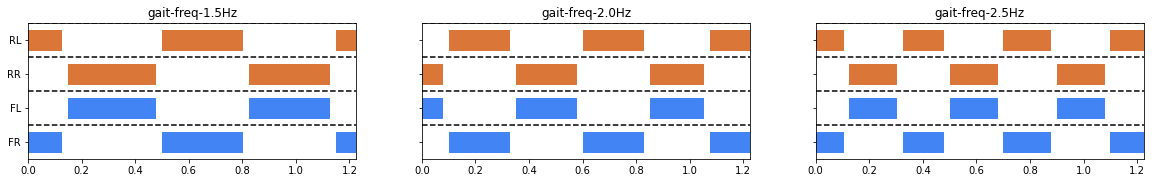

In [ ]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_orange = (219 / 256, 118 / 256, 55 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_blue, google_orange, google_orange]

def plot_foot_contacts(ax, time, foot_contacts, title):
    
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1        
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i])


fig, ax = plt.subplots(1, 3, figsize=(20, 2.5), sharey=True, sharex=True)
# ax[0,0].set_yticks(foot_names)
ax[0].set_ylim(-0.5, 3.5)
ax[0].set_xlim(0, time[-1])
for i, (name, fc) in enumerate(vary_freq_foot_contacts):
    plot_foot_contacts(ax[i], time, fc, title = name)

fig.show()